# KNN with K-Fold Cross

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../Datasets/Social_Network_Ads.csv')
data.head(5)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
data.dtypes

User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

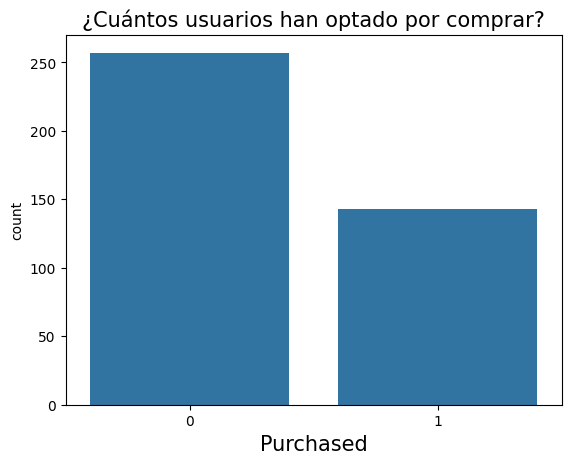

In [4]:
sns.countplot(data = data, x = 'Purchased')
plt.xlabel('Purchased', fontsize = 15)
plt.title('¿Cuántos usuarios han optado por comprar?', fontsize = 15)
plt.show()

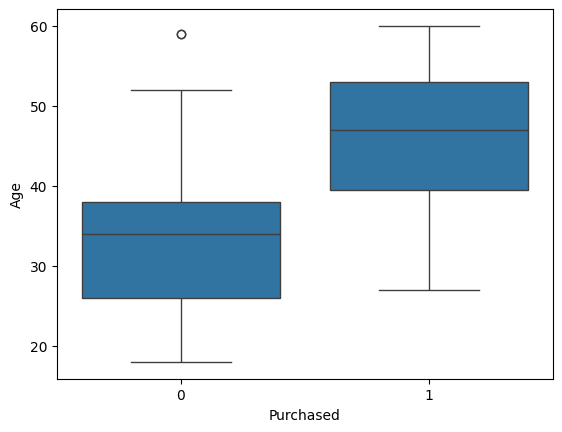

In [5]:
sns.boxplot(x='Purchased',y='Age',data=data)
plt.show()

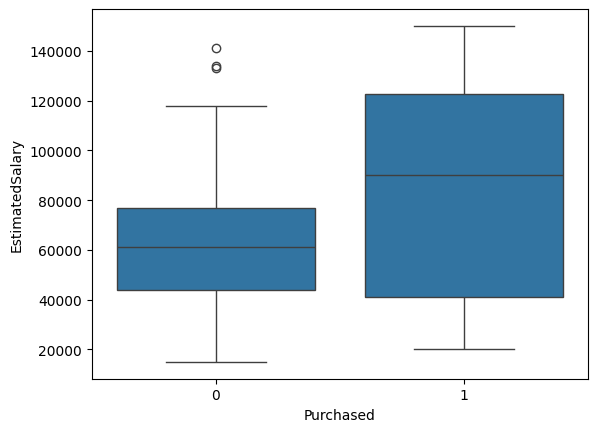

In [6]:
sns.boxplot(x='Purchased',y='EstimatedSalary',data=data)
plt.show()

Gender     Female  Male
Purchased              
0             127   130
1              77    66


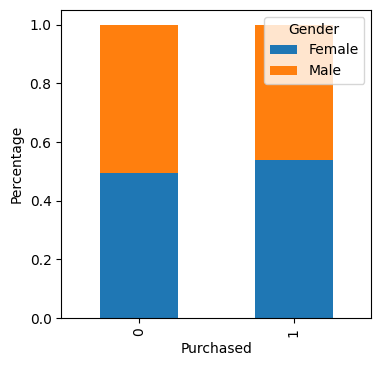

In [7]:
print(pd.crosstab(data["Purchased"],data["Gender"]))
Gender = pd.crosstab(data["Purchased"],data["Gender"])
Gender.div(Gender.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("Purchased")
plt.ylabel("Percentage")
plt.show()

In [8]:
X = data.iloc[:,[2, 3]].values
y = data.iloc[:,-1].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [10]:
transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [19]:
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y, cv=5)
cv_scores

[0.8125 0.8625 0.725  0.7625 0.675 ]


In [20]:
print("cv_scores mean: {}".format(np.mean(cv_scores)))
print("cv_scores std: {}".format(np.std(cv_scores)))

cv_scores mean: 0.7674999999999998
cv_scores std: 0.06547900426854397


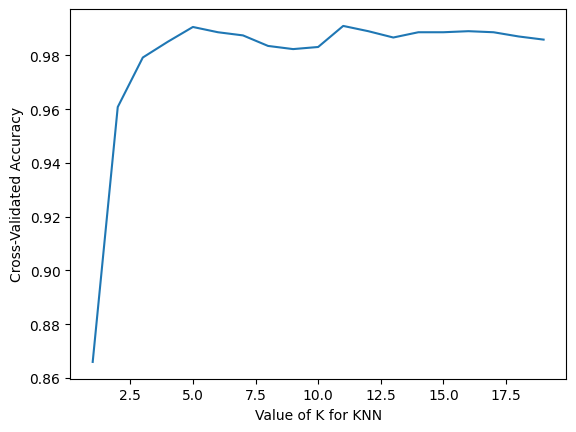

Best K = 11


In [11]:
k_range = range(1, 20)
k_scores = []
best_K = 0
current_auc = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred_KNN = knn.predict(X_test)
    y_pred_prob_KNN = knn.predict_proba(X_test)
    false_positive_rate_KNN, true_positive_rate_KNN, thresholds_KNN = roc_curve(y_test, y_pred_prob_KNN[:,1])
    roc_auc_KNN = auc(false_positive_rate_KNN, true_positive_rate_KNN)
    k_scores.append(roc_auc_KNN)

    if roc_auc_KNN > current_auc:
        current_auc = roc_auc_KNN
        best_K = k
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
print("Best K = " + str(best_K))

In [12]:
classifier = KNeighborsClassifier(n_neighbors=best_K).fit(X_train, y_train)
y_pred = classifier.predict(X_test)

Confusion matrix, without normalization
[[55  3]
 [ 1 21]]
Normalized confusion matrix
[[0.94827586 0.05172414]
 [0.04545455 0.95454545]]


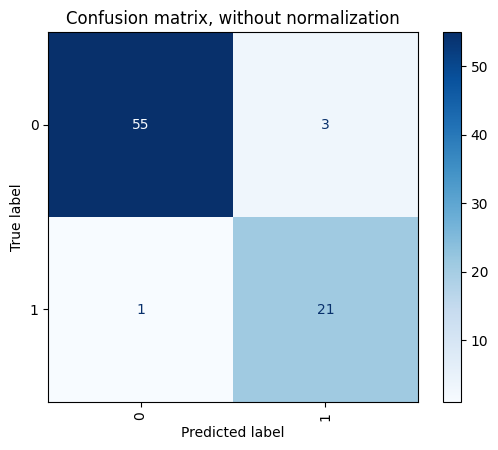

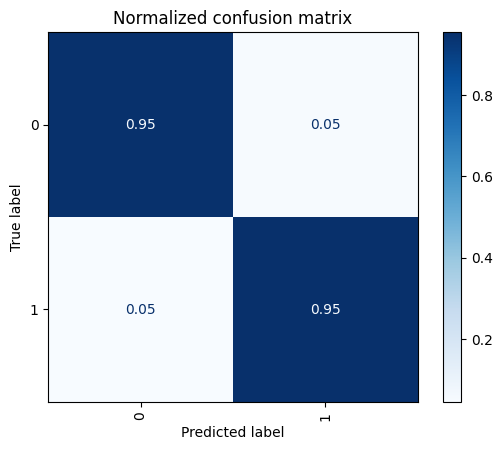

In [23]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
cm = confusion_matrix(y_test, y_pred)
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classifier.classes_)
        disp = disp.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
    else:
        disp = disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')

    disp.ax_.set_title(title)

    print(title)
    print(cm if not normalize else cm_normalized)

plt.show()

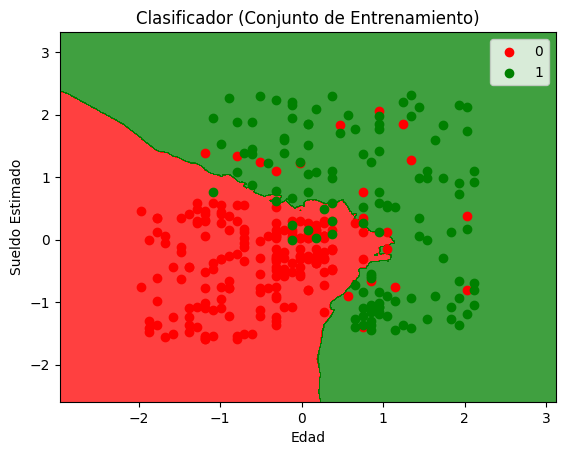

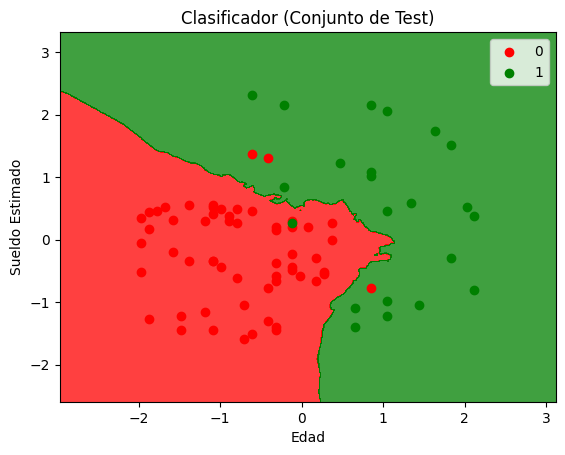

In [16]:
def plot_classifier(classifier, X_set, y_set, xlabel, ylabel, title):
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ['red', 'green'][i], label = j)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_classifier(classifier, X_train, y_train, 'Edad', 'Sueldo Estimado', 'Clasificador (Conjunto de Entrenamiento)')
plot_classifier(classifier, X_test, y_test, 'Edad', 'Sueldo Estimado', 'Clasificador (Conjunto de Test)')

In [24]:
y_pred_prob = classifier.predict_proba(X_test)
y_pred_prob[0:5]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.90909091, 0.09090909],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [26]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9909874608150471

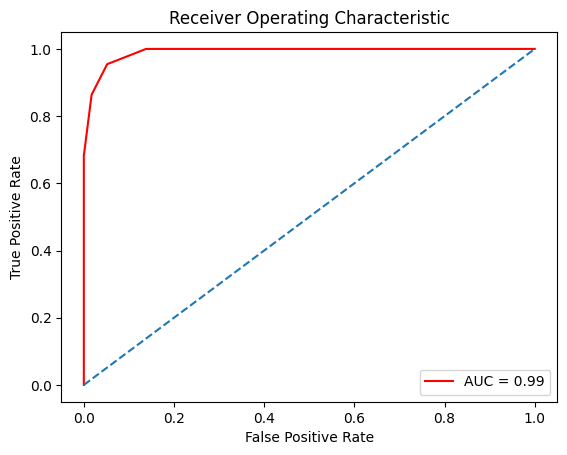

In [27]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
dataf_combined = pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test),pd.DataFrame(y_pred_KNN),pd.DataFrame(y_pred_prob_KNN)],axis=1)
dataf_combined.columns = ['Age', 'EstimatedSalary', 'Purchased', 'Purchased_Pred', 'Purchased_Pred_Prob_0', 'Purchased_Pred_Prob_1']
dataf_combined.head(10)

,Age,EstimatedSalary,Purchased,Purchased_Pred,Purchased_Pred_Prob_0,Purchased_Pred_Prob_1
0,-0.798951,0.494608,0,0,0.894737,0.105263
1,-0.021265,-0.577359,0,0,1.000000,0.000000
2,-0.312897,0.146943,0,0,0.894737,0.105263
3,-0.798951,0.262831,0,0,1.000000,0.000000
4,-0.312897,-0.577359,0,0,1.000000,0.000000
5,-1.090583,-1.446521,0,0,1.000000,0.000000
6,-0.701740,-1.591382,0,0,1.000000,0.000000
7,-0.215686,2.146016,1,1,0.052632,0.947368
8,-1.965480,-0.055862,0,0,1.000000,0.000000
9,0.853632,-0.780164,0,1,0.157895,0.842105


In [34]:
df_original_features = pd.DataFrame(X_test, columns=['Age', 'EstimatedSalary'])
df_original = pd.DataFrame(transformer.inverse_transform(df_original_features), columns=['Age', 'EstimatedSalary'])

df_original[['Purchased', 'Purchased_Pred', 'Purchased_Pred_Prob_0', 'Purchased_Pred_Prob_1']] = dataf_combined[['Purchased', 'Purchased_Pred', 'Purchased_Pred_Prob_0', 'Purchased_Pred_Prob_1']]
df_original.head(10)

,Age,EstimatedSalary,Purchased,Purchased_Pred,Purchased_Pred_Prob_0,Purchased_Pred_Prob_1
0,30.0,87000.0,0,0,0.894737,0.105263
1,38.0,50000.0,0,0,1.000000,0.000000
2,35.0,75000.0,0,0,0.894737,0.105263
3,30.0,79000.0,0,0,1.000000,0.000000
4,35.0,50000.0,0,0,1.000000,0.000000
5,27.0,20000.0,0,0,1.000000,0.000000
6,31.0,15000.0,0,0,1.000000,0.000000
7,36.0,144000.0,1,1,0.052632,0.947368
8,18.0,68000.0,0,0,1.000000,0.000000
9,47.0,43000.0,0,1,0.157895,0.842105


In [35]:
def asignar_categoria(valor):
    if valor <= 0.2:
        return 'MB'  # Muy bajo
    elif valor <= 0.4:
        return 'B'   # Bajo
    elif valor <= 0.6:
        return 'M'   # Medio
    elif valor <= 0.8:
        return 'A'   # Alto
    else:
        return 'MA'  # Muy alto

df_original['Score'] = df_original['Purchased_Pred_Prob_1'].apply(asignar_categoria)
df_original

,Age,EstimatedSalary,Purchased,Purchased_Pred,Purchased_Pred_Prob_0,Purchased_Pred_Prob_1,Score
0,30.0,87000.0,0,0,0.894737,0.105263,MB
1,38.0,50000.0,0,0,1.000000,0.000000,MB
2,35.0,75000.0,0,0,0.894737,0.105263,MB
3,30.0,79000.0,0,0,1.000000,0.000000,MB
4,35.0,50000.0,0,0,1.000000,0.000000,MB
...,...,...,...,...,...,...,...
75,18.0,82000.0,0,0,1.000000,0.000000,MB
76,42.0,79000.0,0,0,0.789474,0.210526,B
77,40.0,60000.0,0,0,1.000000,0.000000,MB
78,53.0,34000.0,1,1,0.052632,0.947368,MA
